### Training data processing

In [1]:
import scanpy as sc
import anndata as ad
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy as sp

from matplotlib import colors

import os
import anndata


/usr/local/lib/python3.6/dist-packages/dask/config.py:168: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}
/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
input_mod1 = ad.read_h5ad('../../fig2/PBMC_data/data/PBMC_10X_GEX.training.h5ad')
input_mod2 = ad.read_h5ad('../../fig2/PBMC_data/data/PBMC_10X_ATAC.training.h5ad')


In [3]:
sc.pp.highly_variable_genes(input_mod1, n_top_genes=8000)

In [4]:
gene_index = pd.read_csv('../../utils/gene_index.txt',header=None)[0].to_numpy()
gene_index = np.intersect1d(gene_index, input_mod2.var_names.to_numpy())
gene_index = np.intersect1d(gene_index, input_mod1.var_names.to_numpy())
len(gene_index)

6245

In [5]:
writer = open('gene_index.txt','w')
writer.write('\n'.join(gene_index))
writer.close()

#### KNN graph distance

/mnt/hdd/chaozhong/pylib/site-packages/scanpy/preprocessing/_simple.py:845: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)


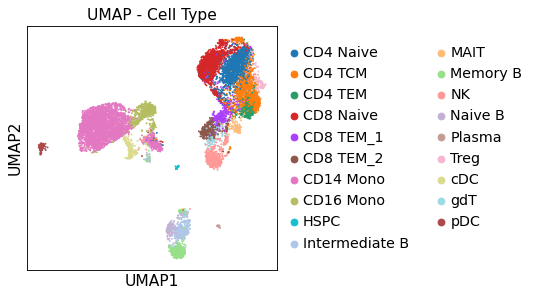

In [6]:
input_mod1 = input_mod1[:,gene_index]
sc.pp.scale(input_mod1, max_value=10)
sc.tl.pca(input_mod1, svd_solver='arpack')
sc.pp.neighbors(input_mod1, n_pcs = 50, n_neighbors = 20)
sc.tl.umap(input_mod1)

#UMAP with Combat batch correction and all genes
sc.set_figure_params(scanpy=True, dpi=80)
sc.pl.umap(input_mod1, color="seurat_annotations", title="UMAP - Cell Type", show=True) #, legend_loc='on data')


In [7]:
input_mod1.obsp['connectivities'][input_mod1.obsp['connectivities'].nonzero()] = 1.01 - input_mod1.obsp['connectivities'][input_mod1.obsp['connectivities'].nonzero()]


In [8]:
#--------------------------------------------------------------------
# This takes time, but saves more time during training
#--------------------------------------------------------------------
from scipy.sparse import csr_matrix
from scipy.sparse.csgraph import dijkstra
import time

start_time = time.time()
dist_matrix = dijkstra(csgraph=input_mod1.obsp['connectivities'], directed=False, return_predecessors=False)
print("--- %s seconds ---" % (time.time() - start_time))


--- 129.89093804359436 seconds ---


In [9]:
input_train_mod1 = ad.read_h5ad('PBMC_10X_GEX.training.h5ad')
input_train_mod1.obsp['distance'] = dist_matrix
input_train_mod1.write('PBMC_10X_GEX.training.h5ad')
